<a href="https://colab.research.google.com/github/Psevdopolughirnikot/-ITC-MTPBN-/blob/main/%D0%93%D1%80%D0%B0%D1%84%D0%B8%D0%BA%D0%B8_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B_%D0%B8%D0%BD%D0%B3%D0%B8%D0%B1%D0%B8%D1%82%D0%BE%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ГРАФИКИ РАБОТЫ ИНГИБИТОРОВ**
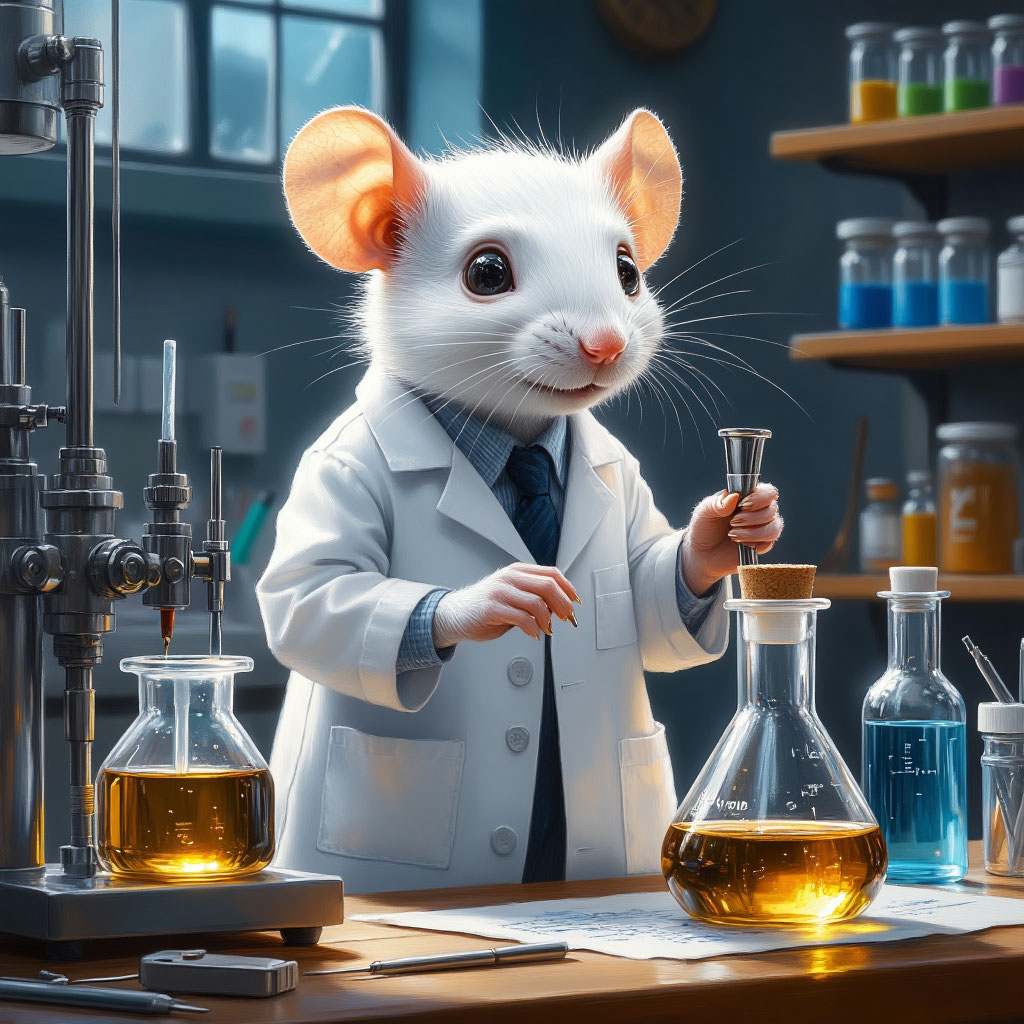

---

**0. Подготовка к запуску кода**

---

In [ ]:
# Список библиотек, необходимых для работы
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import numpy as np
import json
import os
import shutil
from IPython.display import display, HTML
from google.colab import drive

# Подключение к Диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Отдельная обработка одной пробы с представлением графика и продолжительности эксперимента**

---

* 1.1 В следующей ячейке вписываем путь к файлу, по которому нужно строить график

In [ ]:
# Здесь вставить путь с гугл диска к файлу с данными измерения
url = '/content/drive/MyDrive/Анализатор солеотложений/ингибиторы от Маши/СТОУНСКЕЙЛ/луч Стоунскейл (4) 6,5 на 1 г л при 110С.csv' # Скопировать и вставить путь к файлу на подключенном Диске

* 1.2 Запускаем анализ данных. На выходе получаем график и время эксперимента в секундах

/tmp/ipython-input-2157234228.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=['Local_Time'])


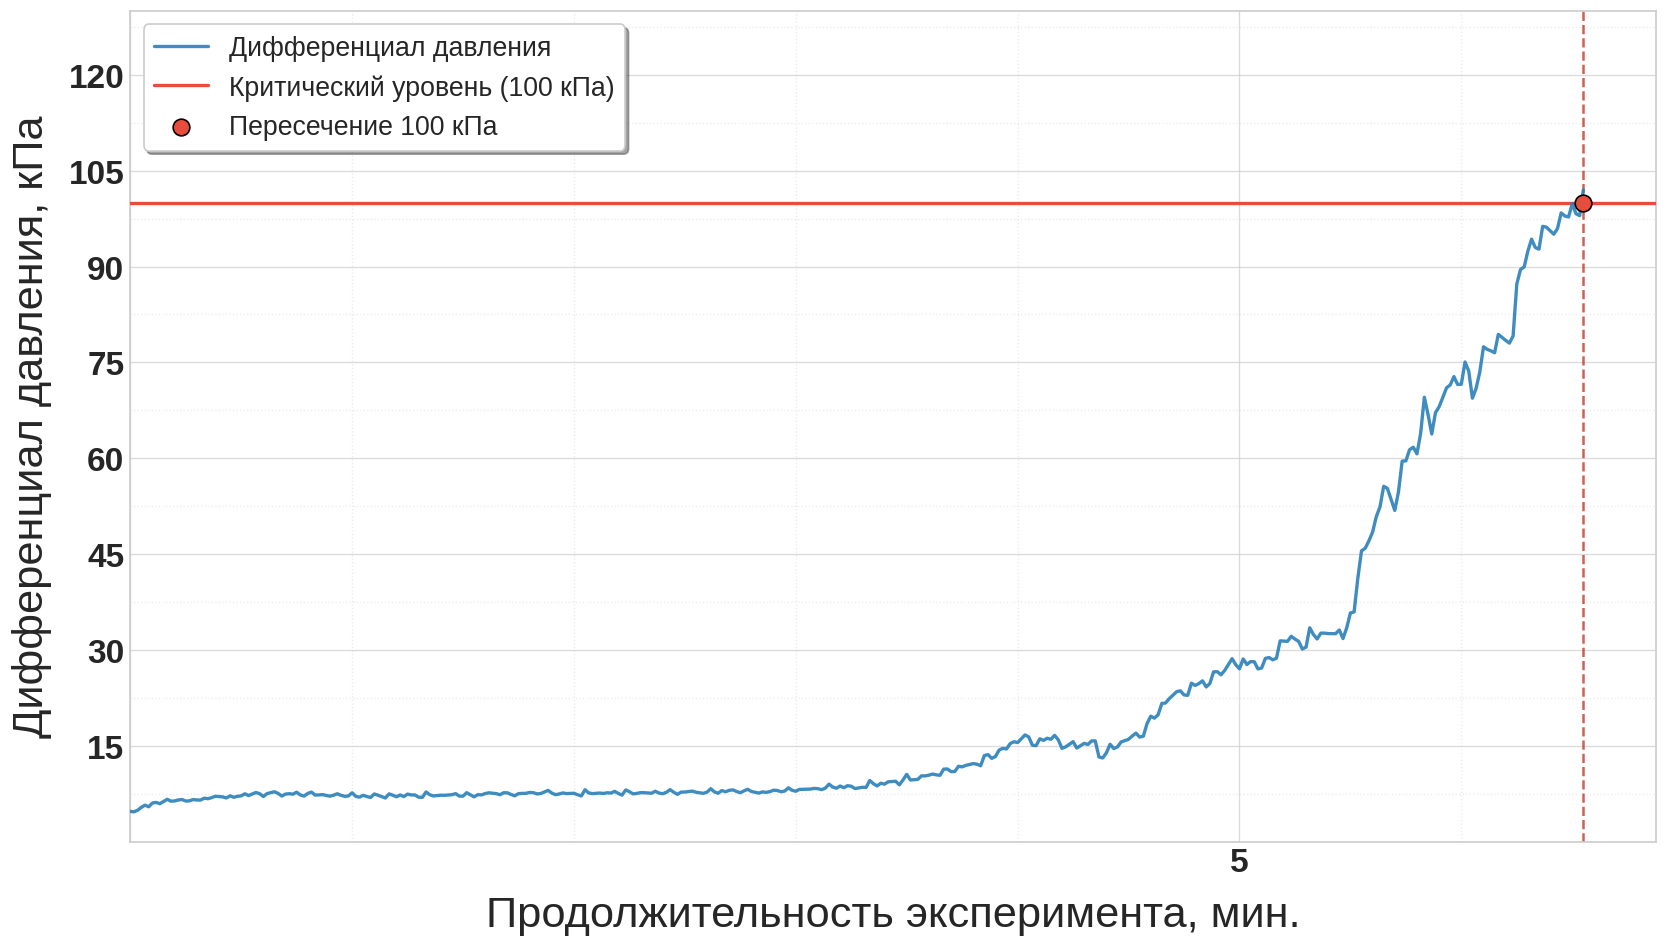

In [ ]:
# @title
# Анализ данных с аппарата DSL (PMAC)

"""
В данном блоке фиксируется время достижения критической отметки дифференциала давления при анализе холостой пробы, переводится в целочисленной значение и записывается в переменную crit_time_seconds
Переменная crit_time_seconds в дальнейшем будет использована для расчёта эффективности работы ингибитора
"""
df = pd.read_csv(url, parse_dates=['Local_Time'])
# Преобразование времени в минуты от начала наблюдений
start_time = df['Local_Time'].iloc[0]
df['Time_min'] = (df['Local_Time'] - start_time).dt.total_seconds() / 60
df['dP_kPa'] = df['dP']  # Для явного указания единиц измерения

# Находим первое пересечение уровня 100 кПа
cross_100 = df[df['dP_kPa'] >= 100]

if not cross_100.empty:
    # Время достижения в минутах
    crit_time_min = cross_100.iloc[0]['Time_min']

    # Преобразование времени в секунды (целое число)
    crit_time_seconds = int(crit_time_min * 60)

# Настройка стиля
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8), dpi=120)
ax = plt.gca()

# Построение основного графика
plt.plot(df['Time_min'], df['dP_kPa'],
         color='#2980b9', # Цвет линии графика
         linewidth=2.0,
         alpha=0.9,
         label='Дифференциал давления',
         zorder=20)

# 1. Красная линия завершения эксперимента (100 кПа)
plt.axhline(y=100, color='#e74c3c', linewidth=2.0, linestyle='-',
            label='Критический уровень (100 кПа)', zorder=12)

# 2. Поиск пиков и впадин для выделения областей
df['dP_diff'] = df['dP_kPa'].diff()

# 3. Выделение максимального пика
max_dp = df['dP_kPa'].max()
max_time = df.loc[df['dP_kPa'] == max_dp, 'Time_min'].values[0]
plt.axvline(max_time, color='#c0392b', linestyle='--', alpha=0.8, linewidth=1.5)

# Настройка осей и сетки
plt.xlabel('Продолжительность эксперимента, мин.', fontsize=26, labelpad=10)
plt.ylabel('Дифференциал давления, кПа', fontsize=26, labelpad=10)

# Настройка шрифта значений на осях X и Y
ax.tick_params(axis='x', labelsize=20)  # Ось X
ax.tick_params(axis='y', labelsize=20)  # Ось Y

# Форматирование оси X (каждые 5 минут)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlim(0, df['Time_min'].max() * 1.05)

# Форматирование оси Y
plt.ylim(0, max_dp * 1.15)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# Размер и жирность подписей делений
ax.tick_params(axis='both', labelsize=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')

def hide_zero(x, pos):
    return "" if x == 0 else f"{x:.0f}"

ax.xaxis.set_major_formatter(ticker.FuncFormatter(hide_zero))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(hide_zero))

# Отметка пересечения критической линии
cross_100 = df[df['dP_kPa'] >= 100]
if not cross_100.empty:
    first_cross = cross_100.iloc[0]['Time_min']
    plt.scatter(first_cross, 100, s=100, zorder=20,
                color='#e74c3c', edgecolor='black',
                label='Пересечение 100 кПа')

# Установка максимального значения оси Y
plt.ylim(0, 130)

# Легенда и дополнительные элементы
plt.legend(fontsize=16, loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.grid(True, which='major', linestyle='-', alpha=0.7)

# Создание графика эксперимента
plt.tight_layout()
plt.savefig('pressure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**2. Обработка результатов испытаний пробы ингибитора**

---

* 2.1 Ячейка создания функций анализа и управления данными измерений продолжительности и дифференциала давления

In [ ]:
# @title

# Инициализация директории для данных измерений, графиков и таблиц
"""
Создание функции анализа данных и сохранение в общий лог
"""


class ExperimentManager:
    def __init__(
        self,
        base_dir='/content/drive/My Drive/Результаты анализов испытаний ингибиторов',
        experiment_batch=None,
        auto_mount=True
        ):

        """
        Инициализация менеджера экспериментов

        Parameters:
        -----------
        base_dir : str
            Базовая директория для всех экспериментов
        experiment_batch : str
            Имя папки для текущей серии экспериментов
            Если None, будет создана с timestamp
        auto_mount : bool
            Автоматически монтировать Google Drive
        """
        if auto_mount:
            self.mount_google_drive()

        self.base_dir = base_dir
        self.experiment_batch = experiment_batch or self.generate_batch_name()

        # Создаем структуру папок
        self.create_directory_structure()

        # Загружаем существующие результаты
        self.load_results()

        print(f"Структура директории анализа испытаний создана:")
        print(f"  Базовая папка: {self.base_dir}")
        print(f"  Серия экспериментов: {self.experiment_batch}")
        print(f"  Папка с данными: {self.data_dir}")
        print(f"  Папка с графиками: {self.graphs_dir}")
        print(f"  Файл результатов: {self.results_file}")

    def mount_google_drive(self):
        """
        Монтирует Google Drive
        """
        try:
            drive.mount('/content/drive')
            print("Google Drive успешно подключен")
        except:
            print("Google Drive уже подключен или произошла ошибка")

    def generate_batch_name(self):
        """
        Генерирует имя для серии экспериментов на основе даты
        """
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
        return f"experiment_batch_{timestamp}"

    def create_directory_structure(self):
        """
        Создает структуру папок для хранения результатов
        """
        # Основная папка для всех экспериментов
        os.makedirs(self.base_dir, exist_ok=True)

        # Папка для текущей серии экспериментов
        self.experiment_dir = os.path.join(self.base_dir, self.experiment_batch)
        os.makedirs(self.experiment_dir, exist_ok=True)

        # Подпапки для разных типов данных
        self.data_dir = os.path.join(self.experiment_dir, 'data')
        self.graphs_dir = os.path.join(self.experiment_dir, 'graphs')
        self.reports_dir = os.path.join(self.experiment_dir, 'reports')

        os.makedirs(self.data_dir, exist_ok=True)
        os.makedirs(self.graphs_dir, exist_ok=True)
        os.makedirs(self.reports_dir, exist_ok=True)

        # Файлы
        self.results_file = os.path.join(self.data_dir, 'experiment_results.json')
        self.summary_file = os.path.join(self.reports_dir, 'experiment_summary.csv')

    def load_results(self):
        """
        Загружает существующие результаты из JSON файла
        """
        if os.path.exists(self.results_file):
            with open(self.results_file, 'r', encoding='utf-8') as f:
                self.results = json.load(f)
            print(f"Загружено {len(self.results)} существующих результатов")
        else:
            self.results = {}
            print("Создан новый файл результатов")

        # Создаем директорию для графиков, если её нет
        if not os.path.exists(self.graphs_dir):
            os.makedirs(self.graphs_dir)

        self.load_results()

    def load_results(self):
        if os.path.exists(self.results_file):
            with open(self.results_file, 'r', encoding='utf-8') as f:
                self.results = json.load(f)
        else:
            self.results = {}

    def analyze_experiment(
        self,
        url,
        show_plot=True,
        save_plot=True,
        copy_original=False
        ):

        """
        Анализирует один файл эксперимента и сохраняет результаты

        Parameters:
        -----------
        url : str
            Путь к CSV файлу
        show_plot : bool
            Показывать ли график в блокноте
        save_plot : bool
            Сохранять ли график в файл
        copy_original : bool
            Копировать ли исходный CSV файл в папку эксперимента
        """
         # Копируем исходный файл, если нужно
        original_path = None
        if copy_original and os.path.exists(url):
            original_name = os.path.basename(url)
            original_path = os.path.join(self.data_dir, original_name)
            shutil.copy2(url, original_path)
            print(f"Исходный файл скопирован в: {original_path}")

        # Загрузка данных
        df = pd.read_csv(url, parse_dates=['Local_Time'])

        # Преобразование времени в минуты от начала наблюдений
        start_time = df['Local_Time'].iloc[0]
        df['Time_min'] = (df['Local_Time'] - start_time).dt.total_seconds() / 60
        df['dP_kPa'] = df['dP']

        # Находим первое пересечение уровня 100 кПа
        cross_100 = df[df['dP_kPa'] >= 100]

        if not cross_100.empty:
            crit_time_min = cross_100.iloc[0]['Time_min']
            crit_time_seconds = int(crit_time_min * 60)
        else:
            print(f"Внимание: уровень 100 кПа не достигнут в {os.path.basename(url)}")
            crit_time_min = None
            crit_time_seconds = None

        # Построение графика
        fig, ax = self.create_pressure_plot(df, crit_time_min, url)

        # Сохранение графика
        graph_path = None
        if save_plot:
            graph_path = self.save_experiment_graph(fig, url)

        # Показать график если нужно
        if show_plot:
            plt.show()
        else:
            plt.close(fig)  # Закрываем фигуру, чтобы не накапливать в памяти

        # Сохранение данных в CSV для возможного повторного использования
        data_filename = os.path.basename(url).replace('.csv', '_processed.csv')
        data_path = os.path.join(self.data_dir, data_filename)
        df.to_csv(data_path, index=False)

        # Сохранение результатов
        result = self.save_experiment_data(
            url,
            df,
            crit_time_seconds,
            crit_time_min,
            graph_path,
            original_path,
            data_path
            )

        return result

    def create_pressure_plot(
                            self,
                            df,
                            crit_time_min,
                            url
                            ):

        """
        Создает график диффренциала давления
        """

        # Настройка стиля
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(14, 8), dpi=120)

        # Построение основного графика
        ax.plot(df['Time_min'], df['dP_kPa'],
                color='#2980b9',
                linewidth=2.0,
                alpha=0.9,
                label='Дифференциал давления',
                zorder=20)

        # Красная линия завершения эксперимента (100 кПа)
        ax.axhline(y=100, color='#e74c3c', linewidth=2.0, linestyle='-',
                   label='Критический уровень (100 кПа)', zorder=12)

        # Выделение максимального пика
        max_dp = df['dP_kPa'].max()
        max_time = df.loc[df['dP_kPa'] == max_dp, 'Time_min'].values[0]
        ax.axvline(max_time, color='#c0392b', linestyle='--', alpha=0.8, linewidth=1.5)

        # Настройка осей и сетки
        ax.set_xlabel('Продолжительность эксперимента, мин.', fontsize=26, labelpad=10)
        ax.set_ylabel('Дифференциал давления, кПа', fontsize=26, labelpad=10)

        # Настройка шрифта значений на осях
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

        # Форматирование оси X (каждые 5 минут)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.set_xlim(0, df['Time_min'].max() * 1.05)

        # Форматирование оси Y
        ax.set_ylim(0, max_dp * 1.15)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

        # Жирность подписей делений
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_weight('bold')

        def hide_zero(x, pos):
            return "" if x == 0 else f"{x:.0f}"

        ax.xaxis.set_major_formatter(ticker.FuncFormatter(hide_zero))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(hide_zero))

        # Отметка пересечения критической линии
        if crit_time_min is not None:
            ax.scatter(crit_time_min, 100, s=100, zorder=20,
                       color='#e74c3c', edgecolor='black',
                       label=f'Пересечение 100 кПа ({crit_time_min:.1f} мин)')
        # Добавляем максимальную область графика на оси Y
        ax.set_ylim(0, 130)

        # Легенда и дополнительные элементы
        ax.legend(fontsize=16, loc='upper left', frameon=True, shadow=True)
        ax.grid(True, which='minor', linestyle=':', alpha=0.4)
        ax.grid(True, which='major', linestyle='-', alpha=0.7)

        # Добавление названия эксперимента в заголовок
        exp_name = os.path.basename(url).replace('.csv', '')
        ax.set_title(f'Испытание: {exp_name}', fontsize=18, pad=20, fontweight='bold')

        plt.tight_layout()
        return fig, ax

    def save_experiment_graph(self, fig, url):

        """
        Сохраняет график в файл
        """

        exp_name = os.path.basename(url).replace('.csv', '')
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        graph_filename = f'{exp_name}_{timestamp}.png'
        graph_path = os.path.join(self.graphs_dir, graph_filename)

        fig.savefig(graph_path, dpi=300, bbox_inches='tight')
        print(f"График сохранен: {graph_path}")

        """
        # На случай, если вдруг понадобится PDF
        pdf_path = os.path.join(self.graphs_dir, f'graph_{exp_name}_{timestamp}.pdf')
        fig.savefig(pdf_path, bbox_inches='tight', facecolor='white')
        return graph_path
        """

    def save_experiment_data(
                              self,
                              url,
                              df,
                              crit_time_seconds,
                              crit_time_min,
                              graph_path=None,
                              original_path=None,
                              processed_path=None
                              ):

        """
        Сохраняет данные эксперимента
        """

        exp_name = os.path.basename(url)

        result = {
            'url': url,
            'experiment_name': exp_name,
            'crit_time_seconds': crit_time_seconds,
            'crit_time_min': crit_time_min,
            'max_pressure': float(df['dP_kPa'].max()),
            'total_duration': float(df['Time_min'].max()),
            'graph_path': graph_path,
            'original_copy_path': original_path,
            'processed_data_path': processed_path,
            'batch_name': self.experiment_batch,
            'processed_date': datetime.now().isoformat(),
            'experiment_dir': self.experiment_dir
        }

        self.results[exp_name] = result

        # Сохраняем в JSON
        with open(self.results_file, 'w', encoding='utf-8') as f:
            json.dump(self.results, f, indent=4, ensure_ascii=False)

        # Сохраняем также в CSV для удобства
        self.save_results_to_csv()

        print(f"\n=== Результат испытания ===")
        print(f"Файл: {exp_name}")
        if crit_time_seconds:
            print(f"Время достижения 100 кПа: {crit_time_seconds} сек ({crit_time_min:.2f} мин)")
        else:
            print(f"Время достижения 100 кПа: не достигнуто")
        #print(f"Максимальное давление: {result['max_pressure']:.2f} кПа")
        if graph_path:
            print(f"График сохранен: {os.path.basename(graph_path)}")

        return result

    def save_results_to_csv(self):
        """
        Сохраняет все результаты в CSV файл
        """
        if not self.results:
            return

        # Конвертируем в DataFrame
        df_results = pd.DataFrame(self.results.values())

        # Сохраняем полный вариант
        df_results.to_csv(self.summary_file, index=False, encoding='utf-8')

        # Сохраняем упрощенный вариант только с ключевыми метриками
        simple_cols = [
                      'experiment_name',
                      'crit_time_seconds',
                      'crit_time_min',
                      'max_pressure',
                      'total_duration',
                      'processed_date'
                      ]
        simple_cols = [c for c in simple_cols if c in df_results.columns]

        simple_file = os.path.join(self.reports_dir, 'experiment_summary_simple.csv')
        df_results[simple_cols].to_csv(simple_file, index=False, encoding='utf-8')

    def get_all_results(self):
        return pd.DataFrame(self.results.values())

    def get_statistics(self):
        df = self.get_all_results()
        stats = {}

        if not df.empty and 'crit_time_seconds' in df.columns:
            valid_times = df['crit_time_seconds'].dropna()
            if len(valid_times) > 0:
                stats = {
                    'mean': valid_times.mean(),
                    'median': valid_times.median(),
                    #'min': valid_times.min(),
                    #'max': valid_times.max(),
                    #'std': valid_times.std(),
                    'count': len(valid_times)
                }

        return stats

    def show_experiment_graph(self, experiment_name):

        """
        Показывает сохраненный график эксперимента
        """

        if experiment_name in self.results:
            graph_path = self.results[experiment_name].get('graph_path')
            if graph_path and os.path.exists(graph_path):
                img = plt.imread(graph_path)
                plt.figure(figsize=(12, 8))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'График: {experiment_name}', fontsize=16)
                plt.show()
            else:
                print(f"График для эксперимента {experiment_name} не найден")
        else:
            print(f"Эксперимент {experiment_name} не найден")

    def print_directory_structure(self):
        """
        Выводит структуру папок эксперимента
        """
        print(f"\nСтруктура папок для серии экспериментов '{self.experiment_batch}':")
        print(f"├── {os.path.relpath(self.experiment_dir, self.base_dir)}/")
        print(f"│   ├── data/")
        print(f"│   │   ├── experiment_results.json")
        print(f"│   │   ├── *_processed.csv")
        print(f"│   │   └── [копии исходных файлов]")
        print(f"│   ├── graphs/")
        print(f"│   │   ├── graph_*.png")
        print(f"│   │   └── graph_*.pdf")
        print(f"│   └── reports/")
        print(f"│       ├── experiment_summary.csv")
        print(f"│       └── experiment_summary_simple.csv")
        print(f"\nПолный путь: {self.experiment_dir}")

    def create_readme_file(self):
        """
        Создает README файл с информацией о серии экспериментов
        """
        readme_path = os.path.join(self.experiment_dir, 'README.md')

        with open(readme_path, 'w', encoding='utf-8') as f:
            f.write(f"# Серия экспериментов: {self.experiment_batch}\n\n")
            f.write(f"Дата создания: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write("## Структура папок\n")
            f.write("- `data/` - исходные и обработанные данные\n")
            f.write("- `graphs/` - графики экспериментов (PNG и PDF)\n")
            f.write("- `reports/` - сводные отчеты в CSV формате\n\n")
            f.write("## Результаты экспериментов\n\n")

            if self.results:
                f.write("| Эксперимент | Время до 100 кПа (сек) | Макс. давление (кПа) |\n")
                f.write("|-------------|------------------------|----------------------|\n")

                for exp_name, result in self.results.items():
                    crit_time = result.get('crit_time_seconds', 'N/A')
                    max_pressure = result.get('max_pressure', 'N/A')
                    f.write(f"| {exp_name} | {crit_time} | {max_pressure:.2f} |\n")

                stats = self.get_statistics()
                if stats:
                    f.write(f"\n## Статистика\n")
                    f.write(f"- Количество экспериментов: {stats.get('count', 0)}\n")
                    f.write(f"- Среднее время: {stats.get('mean', 0):.0f} сек\n")
                    f.write(f"- Медиана: {stats.get('median', 0):.0f} сек\n")
                    f.write(f"- Стандартное отклонение: {stats.get('std', 0):.0f} сек\n")
                    f.write(f"- CV: {stats.get('cv_percent', 0):.1f}%\n")

        print(f"README файл создан: {readme_path}")

  *   2.2 Ячейка создания функции, которая отображает общие результаты испытаний



In [ ]:
# @title
# Функция обобщает рузультаты
def show_experiment_summary(exp_manager):
    """
     Показывает сводку по всем экспериментам

    Parameters:
    -----------
    exp_manager : ExperimentManager
        Экземпляр менеджера экспериментов
    """
    df_results = exp_manager.get_all_results()

    if df_results.empty:
        print("Нет сохраненных экспериментов")
        return

    display(HTML("<h2>Сводная таблица результатов по всем экспериментам</h2>"))

    # Создаем таблицу значений переменной crit_time_seconds
    display_df = df_results.copy()
    if 'graph_path' in display_df.columns:
        # Создаем относительные пути для лучшей читаемости
        def create_graph_link(path):
            if path and os.path.exists(path):
                rel_path = os.path.relpath(path, exp_manager.experiment_dir)
                return f'<a href="{path}" target="_blank">{rel_path}</a>'
            return 'Нет'

        #display_df['График'] = display_df['graph_path'].apply(create_graph_link)

    # Отображаем нужные колонки
    cols_to_show = [
        'experiment_name',
        'crit_time_seconds'
        #'График',
        #'crit_time_min',
        #'max_pressure'
        ]
    cols_to_show = [c for c in cols_to_show if c in display_df.columns]

    display(HTML(display_df[cols_to_show].to_html(escape=False, index=False)))

* 2.3 Ячейка создания функции для одновременного анализа параллельных испытаний

In [ ]:
# @title
# Анализ параллельных испытаний одной пробы

def analyze_multiple_experiments(file_paths,
                                 exp_manager,
                                 show_plots=False,
                                 save_plots=True,
                                 copy_original=True
                                 ):
    """
    Анализирует несколько файлов экспериментов

    Parameters:
    -----------
    file_paths : list
        Список путей к CSV файлам
    show_plots : bool
        Показывать ли графики в процессе анализа
    save_plots : bool
        Сохранять ли графики в файлы
    """
    results = []

    print(f"{'='*70}")
    print(f"Начало анализа серии экспериментов: {exp_manager.experiment_batch}")
    print(f"{'='*70}")

    for i, file_path in enumerate(file_paths, 1):
        print(f"\n{'─'*60}")
        print(f"Эксперимент {i}/{len(file_paths)}: {os.path.basename(file_path)}")
        print(f"{'─'*60}")

        try:
            if not os.path.exists(file_path):
                print(f"Файл не найден: {file_path}")
                continue

            result = exp_manager.analyze_experiment(
                file_path,
                show_plot=show_plots,
                save_plot=save_plots,
                copy_original=copy_original
            )
            results.append(result)

        except Exception as e:
            print(f"Ошибка при анализе файла {file_path}:")
            print(f"  Тип ошибки: {type(e).__name__}")
            print(f"  Сообщение: {str(e)}")

    print(f"\n{'='*70}")
    print(f"Анализ завершен. Обработано: {len(results)}/{len(file_paths)} файлов")

    # Создаем README файл и показываем структуру
    exp_manager.create_readme_file()
    exp_manager.print_directory_structure()

    return results

* 2.4 Ячейка для записи пути к нескольким параллельным испытаниям и представлению общих данных

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive успешно подключен
Структура директории анализа испытаний создана:
  Базовая папка: /content/drive/My Drive/Результаты анализов испытаний ингибиторов
  Серия экспериментов: Dispersol 8260 СК
  Папка с данными: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/data
  Папка с графиками: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/graphs
  Файл результатов: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/data/experiment_results.json
Начало анализа серии экспериментов: Dispersol 8260 СК

────────────────────────────────────────────────────────────
Эксперимент 1/4: Dispersol 8260 CK (1) 6,5 на 1 г л при 110 С.csv
────────────────────────────────────────────────────────────
Исходный файл скопирован в: /content/drive/My Drive/Результаты анализов 

/tmp/ipython-input-2007889905.py:146: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=['Local_Time'])


График сохранен: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/graphs/Dispersol 8260 CK (1) 6,5 на 1 г л при 110 С_20251208_113720.png


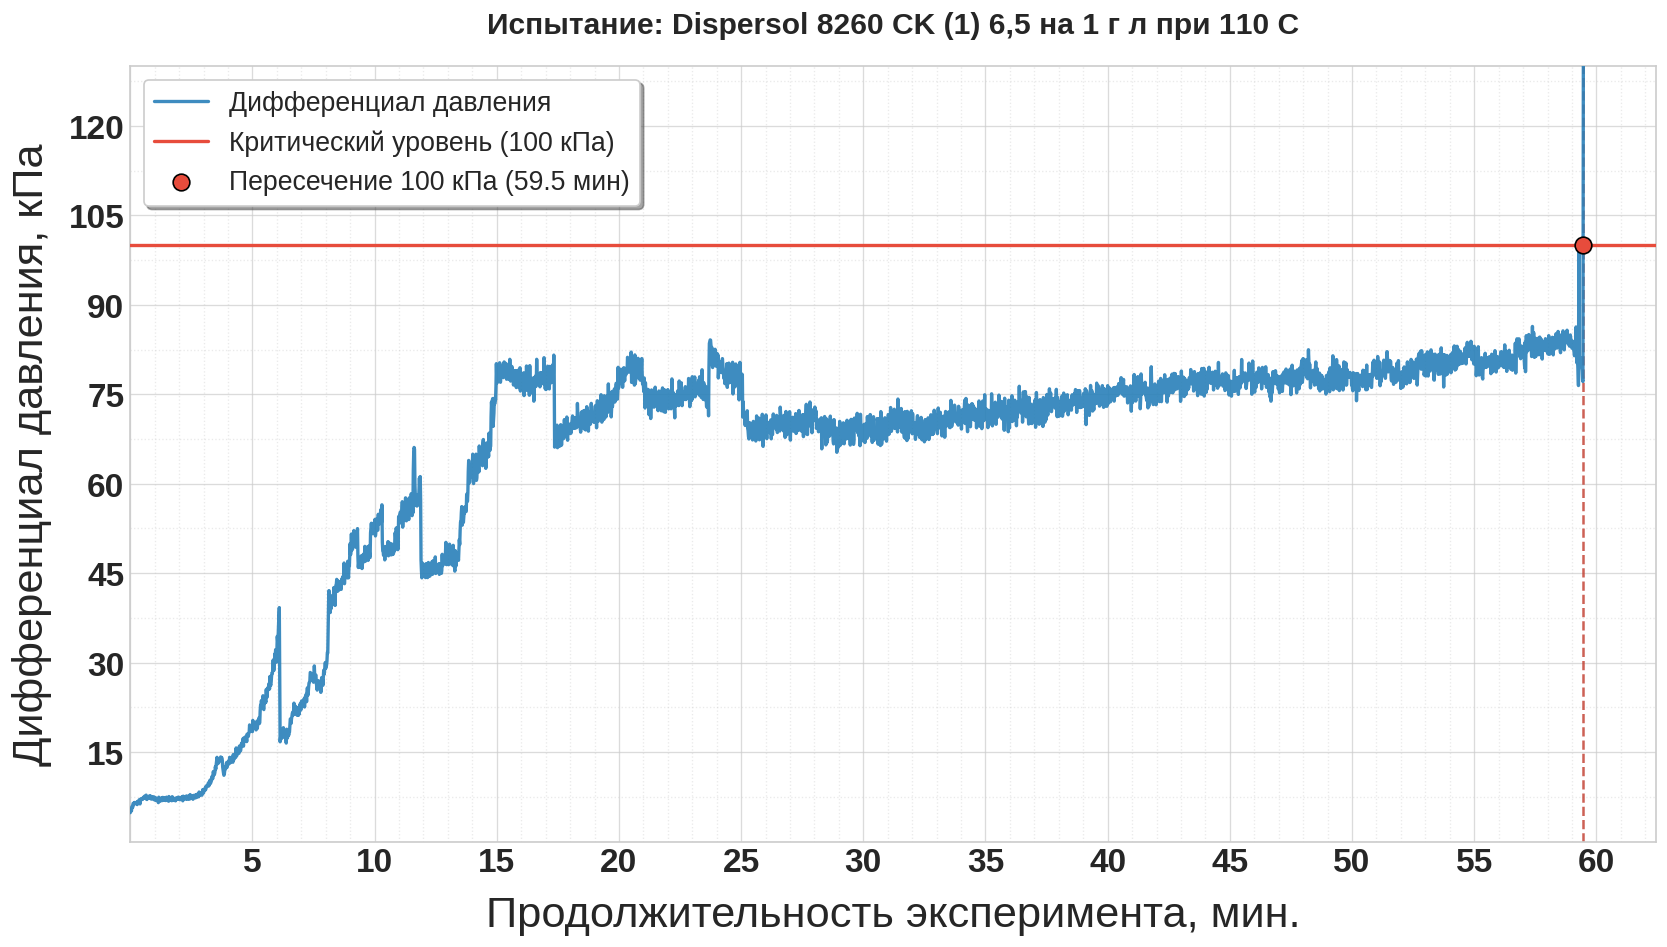


=== Результат испытания ===
Файл: Dispersol 8260 CK (1) 6,5 на 1 г л при 110 С.csv
Время достижения 100 кПа: 3568 сек (59.47 мин)

────────────────────────────────────────────────────────────
Эксперимент 2/4: Dispersol 8260 CK (2) 6,5 на 1 г л при 110С.csv
────────────────────────────────────────────────────────────
Исходный файл скопирован в: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/data/Dispersol 8260 CK (2) 6,5 на 1 г л при 110С.csv


/tmp/ipython-input-2007889905.py:146: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=['Local_Time'])


График сохранен: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/graphs/Dispersol 8260 CK (2) 6,5 на 1 г л при 110С_20251208_113722.png


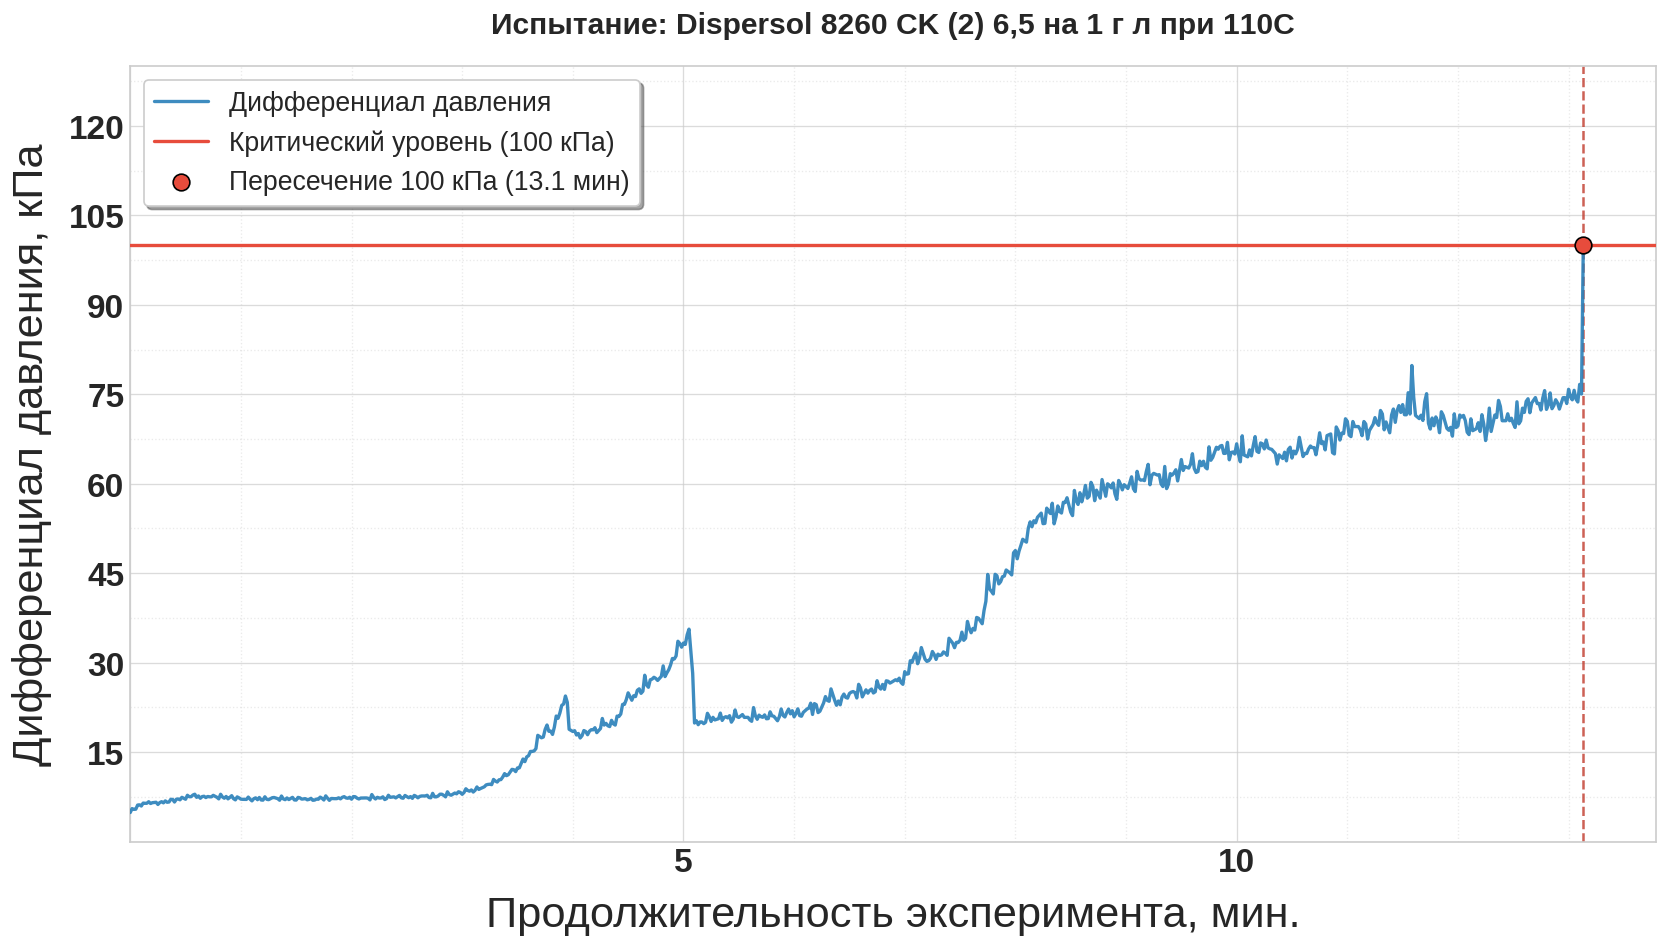


=== Результат испытания ===
Файл: Dispersol 8260 CK (2) 6,5 на 1 г л при 110С.csv
Время достижения 100 кПа: 788 сек (13.13 мин)

────────────────────────────────────────────────────────────
Эксперимент 3/4: луч Dispersol 8260 CK (1) 6,5 0,5 г л при 110С.csv
────────────────────────────────────────────────────────────
Исходный файл скопирован в: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/data/луч Dispersol 8260 CK (1) 6,5 0,5 г л при 110С.csv


/tmp/ipython-input-2007889905.py:146: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=['Local_Time'])


График сохранен: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/graphs/луч Dispersol 8260 CK (1) 6,5 0,5 г л при 110С_20251208_113723.png


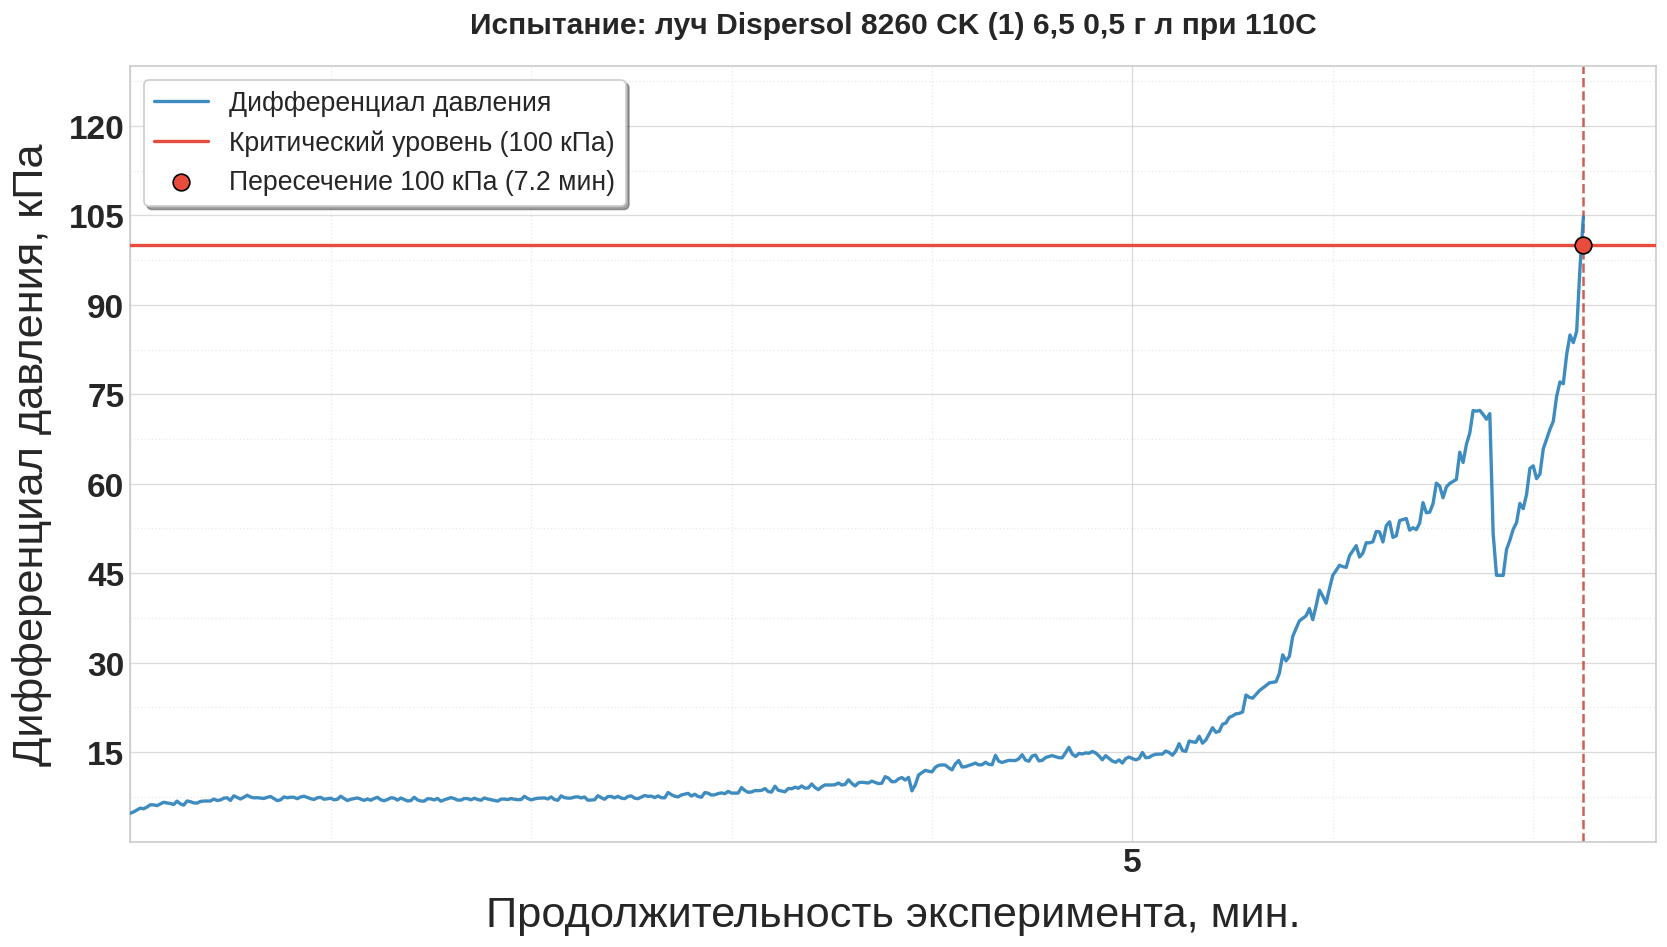


=== Результат испытания ===
Файл: луч Dispersol 8260 CK (1) 6,5 0,5 г л при 110С.csv
Время достижения 100 кПа: 435 сек (7.25 мин)

────────────────────────────────────────────────────────────
Эксперимент 4/4: луч Dispersol 8260 CK (3) 6.5 на 1 г л при 110С.csv
────────────────────────────────────────────────────────────
Исходный файл скопирован в: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/data/луч Dispersol 8260 CK (3) 6.5 на 1 г л при 110С.csv


/tmp/ipython-input-2007889905.py:146: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=['Local_Time'])


График сохранен: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/graphs/луч Dispersol 8260 CK (3) 6.5 на 1 г л при 110С_20251208_113724.png


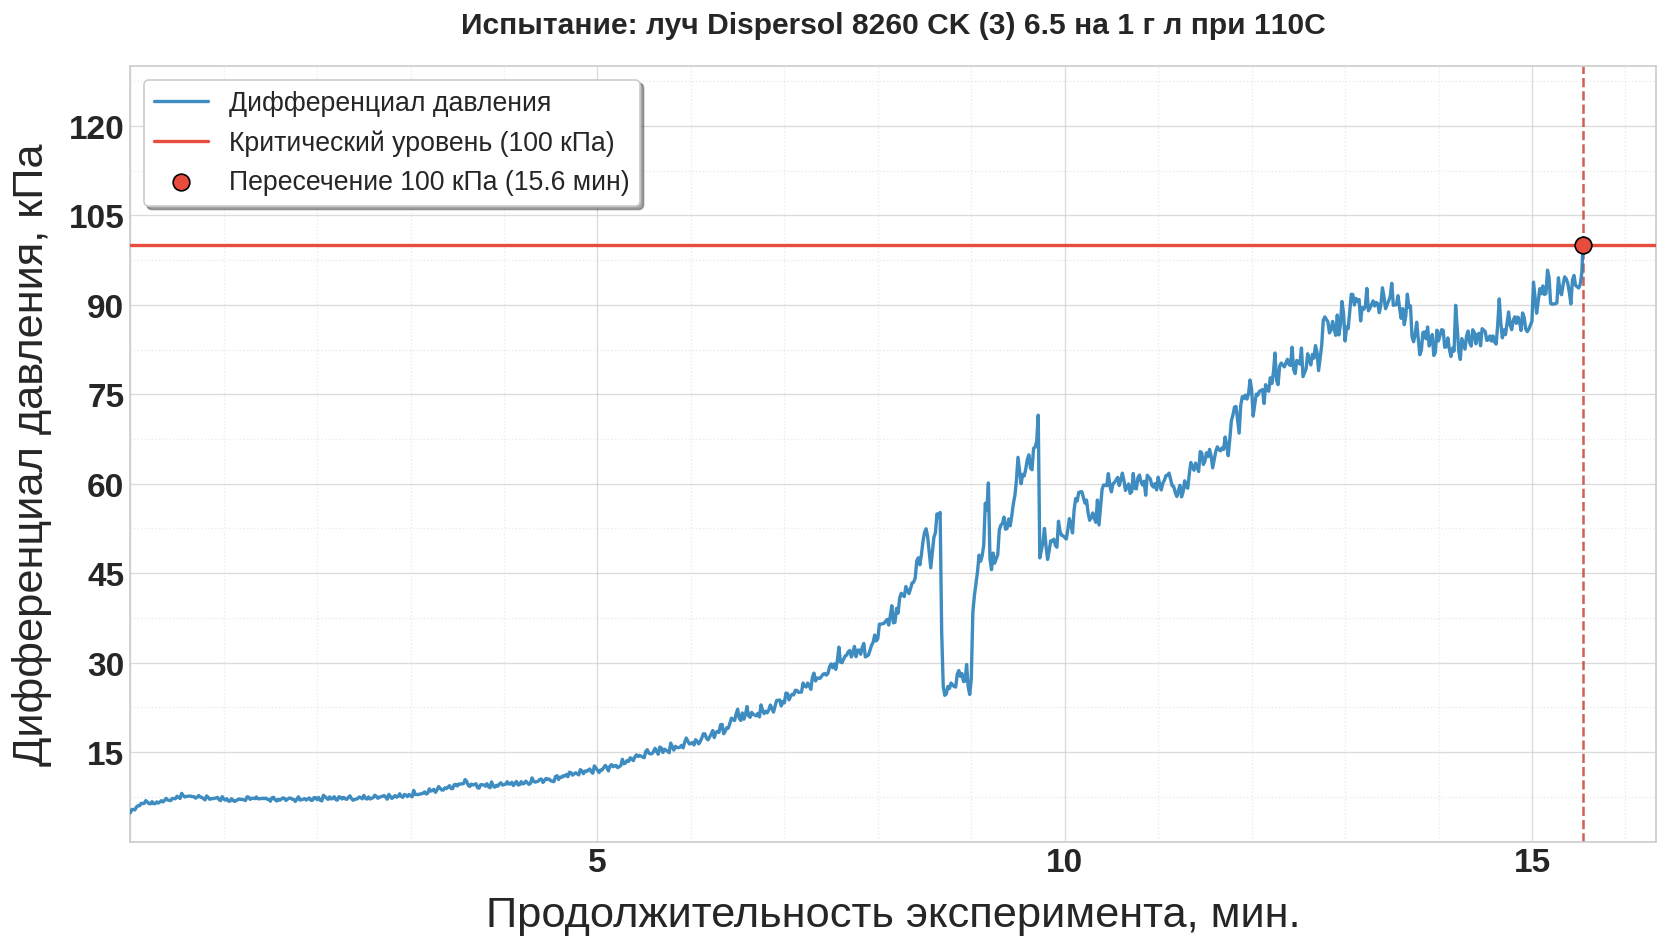


=== Результат испытания ===
Файл: луч Dispersol 8260 CK (3) 6.5 на 1 г л при 110С.csv
Время достижения 100 кПа: 933 сек (15.55 мин)

Анализ завершен. Обработано: 4/4 файлов
README файл создан: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК/README.md

Структура папок для серии экспериментов 'Dispersol 8260 СК':
├── Dispersol 8260 СК/
│   ├── data/
│   │   ├── experiment_results.json
│   │   ├── *_processed.csv
│   │   └── [копии исходных файлов]
│   ├── graphs/
│   │   ├── graph_*.png
│   │   └── graph_*.pdf
│   └── reports/
│       ├── experiment_summary.csv
│       └── experiment_summary_simple.csv

Полный путь: /content/drive/My Drive/Результаты анализов испытаний ингибиторов/Dispersol 8260 СК


experiment_name,crit_time_seconds
"Dispersol 8260 CK (1) 6,5 на 1 г л при 110 С.csv",3568
"Dispersol 8260 CK (2) 6,5 на 1 г л при 110С.csv",788
"луч Dispersol 8260 CK (1) 6,5 0,5 г л при 110С.csv",435
луч Dispersol 8260 CK (3) 6.5 на 1 г л при 110С.csv,933


In [ ]:
"""
В данной ячейке создается структура сохранения серии эжксперимента на диске.
Записываются пути к файлам, которые необходимо проанализировать.
Запись путей производится в список experiment_files.
"""
# Управление параметрами сохранения данных
exp_manager = ExperimentManager(
    base_dir='/content/drive/My Drive/Результаты анализов испытаний ингибиторов',  # Основная папка, в которую будут сохраняться все данные анализа. Можно изменять при необходимости. Но лучше не надо ...
    experiment_batch='Dispersol 8260 СК',                   # Название папки серии экспериментов. Можно изменять в зависимости, например, от названия ингибитора или холостой пробы
    auto_mount=True                                         # Автоматически подключить Google Drive. На всякий случай если не выполнен вход ранее
)
# Список файлов для анализа
# Количетсво образцов не ограничено. Можно вставлять путь на всю серию целиком или несколько серий. ВАЖНО! После вставки пути к образцу нужно ставить запятую. Запятая не ставится только после послежнего в спике пути
# Необходимо вставить путь на холостую пробу, так как далее по ней будет произведен расчёт
experiment_files = [
    '/content/drive/MyDrive/Анализатор солеотложений/ингибиторы от Маши/Dispersol 8260 CK (20 11 25)/Dispersol 8260 CK (1) 6,5 на 1 г л при 110 С.csv',
    '/content/drive/MyDrive/Анализатор солеотложений/ингибиторы от Маши/Dispersol 8260 CK (20 11 25)/Dispersol 8260 CK (2) 6,5 на 1 г л при 110С.csv',
    '/content/drive/MyDrive/Анализатор солеотложений/ингибиторы от Маши/Dispersol 8260 CK (20 11 25)/луч Dispersol 8260 CK (1) 6,5 0,5 г л при 110С.csv',
    '/content/drive/MyDrive/Анализатор солеотложений/ингибиторы от Маши/Dispersol 8260 CK (20 11 25)/луч Dispersol 8260 CK (3) 6.5 на 1 г л при 110С.csv'
]

# Анализ всех файлов
results = analyze_multiple_experiments(
    experiment_files,
    exp_manager=exp_manager,
    show_plots=True,      # Показывать графики в процессе анализа (True/False)?
    save_plots=True,      # Сохранять графики в файлы (True/False)?
    copy_original=True    # Копировать исходный файл (True/False)?
)

# Показать сводку всех экспериментов
show_experiment_summary(exp_manager)

**2.5 Ячейка расчёта эффективности работы ингибитора**

In [ ]:
# @title

def interactive_average_calculation_with_efficiency(df):
    """
    Расчет среднего с выбором строк и расчетом эффективности
    Поддерживает ввод как индексов, так и номеров строк
    """
    # Показать таблицу с нумерацией строк
    print("=== Таблица данных ===")
    print(df[['crit_time_seconds']].reset_index().to_string(index=True))
    print()

    # Показать доступные индексы
    print("Доступные индексы:")
    for i, idx in enumerate(df.index, 1):
        print(f"  {i}. {idx}")
    print()

    # Шаг 1: Выбор строк для расчета среднего
    print("--- Шаг 1: Выбор строк для расчета ---")
    print("Можно вводить:")
    print("  1. Индексы (например: exp1, exp3). Регистр имеет значение")
    print("  2. Номера строк (например: 1, 3)")
    print("  3. Диапазон номеров (например: 1:3 или 2-4)")
    print("  4. Оставить пустым для выбора всех строк")

    user_input = input("\nВведите выбор: ").strip()

    if user_input == "":
        selected_df = df
        print("Выбраны все строки")
    else:
        selected_indices = []

        # Обработка различных форматов ввода
        for item in user_input.split(','):
            item = item.strip()

            # Проверяем, является ли ввод номером строки
            if item.isdigit():
                num = int(item)
                if 1 <= num <= len(df):
                    selected_indices.append(df.index[num-1])
                else:
                    print(f"Предупреждение: номер {num} вне диапазона (1-{len(df)})")

            # Проверяем диапазон номеров (например: 1:3 или 2-4)
            elif ':' in item or '-' in item:
                try:
                    # Заменяем разделитель на двоеточие для унификации
                    range_str = item.replace('-', ':')
                    start, end = map(int, range_str.split(':'))

                    # Преобразуем в индексы
                    for num in range(start, end+1):
                        if 1 <= num <= len(df):
                            selected_indices.append(df.index[num-1])
                except:
                    print(f"Ошибка в формате диапазона: {item}")

            # Иначе считаем, что это имя индекса
            else:
                if item in df.index:
                    selected_indices.append(item)
                else:
                    print(f"Предупреждение: индекс '{item}' не найден")

        # Убираем дубликаты
        selected_indices = list(set(selected_indices))

        if selected_indices:
            selected_df = df.loc[selected_indices]
            print(f"Выбраны значения: {selected_indices}")
        else:
            print("Нет корректных индексов, используются все")
            selected_df = df

    # Расчет среднего времени для выбранных строк
    if 'crit_time_seconds' in selected_df.columns:
        average_result = selected_df['crit_time_seconds'].mean()
        print(f"\n=== Результаты шага 1 ===")
        print(f"Количество выбранных значений: {len(selected_df)}")
        print(f"Среднее значение выборки: {average_result:.3f}")
        print(f"\nВыбранные данные:")
        print(selected_df[['crit_time_seconds']])

    # Шаг 2: Ввод времени холостой пробы
    print("\n" + "="*50)
    print("--- Шаг 2: Ввод времени холостой пробы ---")
    while True:
        try:
            holost_proba = float(input("\nВведите время холостой пробы в секундах: ").strip())
            if holost_proba <= 0:
                print("Ошибка: время должно быть положительным числом!")
                continue
            break
        except ValueError:
            print("Ошибка: введите целое числовое значение (например: 300 или 555)")
        except Exception as e:
            print(f"Произошла ошибка: {e}")

    print(f"Время холостой пробы установлено: {holost_proba} с")

    # Шаг 3: Расчет эффективности ингибитора
    print("\n" + "="*50)
    print("--- Шаг 3: Расчет эффективности ингибитора ---")
    print(f"Формула: Эф = (t1 / t0) * 100,")
    print(f"где:")
    print(f"t0 - продолжительность испытания холостой пробы, с;")
    print(f"t1 - продолжительность испытания с ингибитором, с.")

    # Выполняем расчет
    efficiency = (average_result / holost_proba) * 100

    print(f"\n" + "="*50)
    print("=== ИТОГОВЫЙ РЕЗУЛЬТАТ ===")
    print(f"Среднее время с ингибитором: {average_result:.1f} с")
    print(f"Время холостой пробы: {holost_proba} с")
    print(f"Эффективность ингибитора = {efficiency:.1f}%")

    # Интерпретация результата
    print(f"\nВыводы по результатам эксперимента:")
    if efficiency < 100:
        print(f"  • Ингибитор ускорил забивание капилляра на {100 - efficiency:.1f}%")
    elif efficiency == 100:
        print(f"  • Ингибитор не оказал эффекта")
    else:
        print(f"  • Ингибитор увеличил продолжительность испытания на {efficiency - 100:.1f}%")

    return {
        'average_result': average_result,
        'holost_proba': holost_proba,
        'efficiency': efficiency,
        'selected_indices': selected_indices,
        'selected_data': selected_df
    }

# Создаем DataFrame из вашего словаря
df = exp_manager.get_all_results()

# Запускаем расчет с эффективностью
results = interactive_average_calculation_with_efficiency(df)

=== Таблица данных ===
   index  crit_time_seconds
0      0               3568
1      1                788
2      2                435
3      3                933

Доступные индексы:
  1. 0
  2. 1
  3. 2
  4. 3

--- Шаг 1: Выбор строк для расчета ---
Можно вводить:
  1. Индексы (например: exp1, exp3). Регистр имеет значение
  2. Номера строк (например: 1, 3)
  3. Диапазон номеров (например: 1:3 или 2-4)
  4. Оставить пустым для выбора всех строк

Введите выбор: 1
Выбраны значения: [0]

=== Результаты шага 1 ===
Количество выбранных значений: 1
Среднее значение выборки: 3568.000

Выбранные данные:
   crit_time_seconds
0               3568

--- Шаг 2: Ввод времени холостой пробы ---
Время холостой пробы - это продолжительность испытания
без ингибитора, с которым сравниваются данные при использовании ингибитора.

Введите время холостой пробы в секундах: 555
Время холостой пробы установлено: 555.0 с

--- Шаг 3: Расчет эффективности ингибитора ---
Формула: Эф = (t1 / t0) * 100,
где:
t0 - пр